In [1]:
import os
os.getcwd()

'/Users/kwonk/Documents/Bootcamp/Twitter-Sentiment-Analysis/LSTM'

In [2]:
import numpy as np 
import pandas as pd 
import seaborn

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(os.listdir("../LSTM/input"))

['.DS_Store', 'test.csv', 'train.csv']


In [3]:
# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm

In [4]:
# Use Keras Tensorflow deeplearning library
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

#set random seed for the session and also for tensorflow that runs in background for keras
set_random_seed(123)
random.seed(123)

Using TensorFlow backend.


In [5]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from matplotlib.pylab import rcParams

from sklearn.metrics import roc_curve,auc,make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import eli5 # for permutation importance
from eli5.sklearn import PermutationImportance

import shap # for SHAP value
from pdpbox import pdp, info_plots # flor partial plots 

np.random.seed(123)
pd.options.mode.chained_assignment = None  #hide any pandas warnings
%matplotlib inline

In [6]:
# Load Dataset
train= pd.read_csv("../LSTM/input/train.csv")
test = pd.read_csv("../LSTM/input/test.csv")

train.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
# pip install ftfy
# import ftfy
# ftfy.fix_text(train[train['tweet']])

In [8]:
train.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [9]:
# Train dataset: Need only class as "Sentiment" and text as 'Phrase'
train = train.rename(columns={'class':'Sentiment','tweet':'Phrase'})
train = train.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],axis=1).copy()
train.head()

,Sentiment,Phrase
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [10]:
test.head()

,Text,Date,Favorites,Retweets,Tweet ID
0,Nielson Media Research final numbers on ACCEPT...,7/30/16 23:32,13850,4130,7.600000e+17
1,Thank you to all of the television viewers tha...,7/30/16 19:00,27659,6842,7.600000e+17
2,Can you imagine if I had the small crowds that...,7/30/16 18:28,19968,6488,7.600000e+17
3,NATO commander agrees members should pay up vi...,7/30/16 18:24,11624,4668,7.600000e+17
4,"Wow, NATO's top commander just announced that ...",7/30/16 18:18,23922,7819,7.600000e+17


In [11]:
test.columns

Index(['Text', 'Date', 'Favorites', 'Retweets', 'Tweet ID'], dtype='object')

In [12]:
# Test dataset: Need only text as 'Phrase'
test = test.rename(columns={'Text':'Phrase'})
test = test.drop(['Date', 'Favorites', 'Retweets', 'Tweet ID'],axis=1).copy()
test.head()

,Phrase
0,Nielson Media Research final numbers on ACCEPT...
1,Thank you to all of the television viewers tha...
2,Can you imagine if I had the small crowds that...
3,NATO commander agrees members should pay up vi...
4,"Wow, NATO's top commander just announced that ..."


In [13]:
train.shape

(24778, 2)

In [14]:
train.dtypes

Sentiment     int64
Phrase       object
dtype: object

In [15]:
test.shape

(29886, 1)

In [16]:
test.dtypes

Phrase    object
dtype: object

In [17]:
# Clean tweets, tokenize, and lemmatize
#     remove html content
#     remove non-alphabetic characters
#     tokenize the sentences
#     lemmatize each word to its lemma (the basic or stem of that word)
        # ex) playing --> play

In [18]:
def clean_sentences(df):
    tweets = []
    
    for sent in tqdm(df['Phrase']):
        
        # remove non-alphabetic characters
        tweet_text = tweet_text = re.sub("[^a-zA-Z]"," ", str(sent))
        
        #remove html content
        tweet_text = BeautifulSoup(tweet_text).get_text()
        
        # tokenize
        words = word_tokenize(tweet_text.lower())
        
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        tweets.append(lemma_words)
        
    return(tweets)

In [19]:
# cleaned tweets for both train and test set retrieved

train_sentences = clean_sentences(train)

100%|██████████| 24778/24778 [00:11<00:00, 2190.13it/s]


In [20]:
test_sentences = clean_sentences(test)

100%|██████████| 29886/29886 [00:11<00:00, 2537.56it/s]


In [21]:
print(len(train_sentences))
print(len(test_sentences))

24778
29886


In [22]:
train_sentences[3]

['rt',
 'c',
 'g',
 'anderson',
 'viva',
 'based',
 'she',
 'look',
 'like',
 'a',
 'tranny']

In [23]:
test_sentences[1000]

['heading',
 'to',
 'rally',
 'with',
 'bobby',
 'now',
 'see',
 'you',
 'soon',
 'pic',
 'twitter',
 'com',
 'dwssoectzn']

In [24]:
# Collect dependent values and convert to ONE-HOT encoding
# Output using to_categorical
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [25]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_sentences,y_target,test_size=0.2,random_state=42,stratify=y_target)

In [26]:
# Getting the no of unique words and max length of a tweet available in the list of cleaned tweets
# It is needed for initializing tokenizer of keras and subsequent padding

# Build an unordered collection of unique elements.
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max=len(sent)

# length of the list of unique_words gives the no of unique words

print(len(list(unique_words)))
print(len_max)


100%|██████████| 19822/19822 [00:00<00:00, 502089.50it/s]

28701
53


In [27]:
# Actual tokenizer of keras and convert to sequences

tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

# texts_to_sequences
# ARGUMENTS: list of texts to turn to sequences
# RETURN: list of sequences (one per text input)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

In [28]:
# Padding is done to equalize the lengths of all input tweets.
# LTSM networks need all inputs to be same length.
# Therefore, tweets lesser than max length will be made equal using extra zeros at end. This is padding.
# Also, you always have to give a three-dimensional array as an input to your LSTM network

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape,y_val.shape,y_train.shape)

(19822, 53) (4956, 53) (29886, 53) (4956, 3) (19822, 3)


In [29]:
# Early stopping to prevent overfitting deep learning neural network models
# This is a method that allows you to specify an arbitrary large number of training epochs.
# This stops training once the model performance stops improving on a hold out validation dataset


early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor = 'val_acc', patience = 2)
callback = [early_stopping]


In [30]:
# Model with Keras LSTM
# Multilayer Perceptron (MLP) for multi-class softmax classification
# Build NLP model called: Long Short Term Memory Network
# This model works on sequenced data
# It's good for NLP task like tagging and text classification
# It treats text as a sequence rather than a bag of words or as ngrams

In [31]:
# LSTM hyperparameters for reference

# Embedding(
#     input_dim,
#     output_dim,
#     embeddings_initializer='uniform',
#     embeddings_regularizer=None,
#     activity_regularizer=None,
#     embeddings_constraint=None,
#     mask_zero=False,
#     input_length=None,
#     **kwargs,
# )

# LSTM(
#     units,
#     activation='tanh',
#     recurrent_activation='hard_sigmoid',
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     recurrent_initializer='orthogonal',
#     bias_initializer='zeros',
#     unit_forget_bias=True,
#     kernel_regularizer=None,
#     recurrent_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     recurrent_constraint=None,
#     bias_constraint=None,
#     dropout=0.0,
#     recurrent_dropout=0.0,
#     implementation=1,
#     return_sequences=False,
#     return_state=False,
#     go_backwards=False,
#     stateful=False,
#     unroll=False,
#     **kwargs,
# )

![lstm_network](../LSTM/figures/lstm_network.png)

In [32]:
# model = Sequential()

In [33]:
# model.add(Embedding(len(list(unique_words)),300,input_length=len_max))

In [34]:
# If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)
# Tensorflow’s num_units is the size of the LSTM’s hidden state (which is also the size of the output if 
# no projection is used). To make the name num_units more intuitive, you can think of it as the number of hidden units in the LSTM cell, 
# or the number of memory units in the cell.
# model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))

In [35]:
# if return_sequence is False, the output is a 2D array. (batch_size, units)
# model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))

In [36]:
# model.add(Dense(100,activation='relu'))

In [37]:
# model.add(Dropout(0.5))
# help reducing interdependent learning amongst the neurons by ignoring certain neurons at random at each training stage 

In [38]:
# model.add(Dense(num_classes,activation='softmax'))

In [39]:
# model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])

In [40]:
# model.summary()

In [41]:
# re-run model everytime new parameter changes (must run sequential to initialize epoch)

model = Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 300)           8610300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 53, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)      

In [42]:
# hyperparameter tuning
# EPOCH: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
# As the number of epochs increases, more number of times the weight are changed in the neural network 
# and the curve goes from underfitting to optimal to overfitting curve.

# BATCH: Total number of training examples present in a single batch. 
#you can’t pass the entire dataset into the neural net at once. 
# So, you divide dataset into Number of Batches or sets or parts.

# ITERATION: Iterations is the number of batches needed to complete one epoch.
# Ex) Our train n=19822
# With batch size of 200, there are 99 iterations for 1 epoch.

In [43]:
# Create weights: Our dataset has only 5.8% HATE, 16.8% Neither and majority 77.4% Offensive 
# To balance the classifiers, we will set Hate and Offensive weights greater than Offensive

In [44]:
# create pandas df for y_train
# Describe classifier hate (0), offensive (1), neither or neutral (2)

y_df = pd.DataFrame(y_train)
y_df.describe()

,0,1,2
count,19822.000000,19822.000000,19822.000000
mean,0.057714,0.774291,0.167995
std,0.233225,0.418088,0.373885
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [45]:
# Sum up the no. of records for each classifier
hate_num = y_df[0].sum()
offensive_num = y_df[1].sum()
neutral_num = y_df[2].sum()

In [46]:
# check hate (1144/19822 = 5.8%)
hate_num

1144.0

In [47]:
# check offensive (15348/19822 = 77.4%)
offensive_num

15348.0

In [48]:
# check neutral (3333/19822 = 16.8%)
neutral_num

3330.0

In [49]:
# Do inverse ratio so that hate and neutral has a higher weight
1 - hate_num / len(y_df)

0.9422863485016648

In [50]:
1 - neutral_num / len(y_df)

0.8320048431036222

In [51]:
# Inverse ratio will give offensive a lower weight
1 - offensive_num / len(y_df)

0.22570880839471297

In [52]:
# fit the model adjusting for epochs, batch, and weight

history = model.fit(
    X_train, y_train, 
    validation_data=(X_val,y_val),
    epochs=15, #may not run all 10 due to callback
    batch_size=256, #faster with larger batch_size but it's generalizing
    verbose=1,
    callbacks=callback, #stops training once the model stops improving. Prevents overfitting.
    class_weight={0: .94*100, 1: .23, 2: .83*10} #use inverse ratio to set hate with highest weight (somewhat arbitrary)
) 

Instructions for updating:
Use tf.cast instead.
Train on 19822 samples, validate on 4956 samples
Epoch 1/15
19822/19822 [==============================] - 73s 4ms/step - loss: 4.0486 - acc: 0.0990 - val_loss: 2.8916 - val_acc: 0.1477
Epoch 2/15
19822/19822 [==============================] - 68s 3ms/step - loss: 1.9300 - acc: 0.1943 - val_loss: 2.5536 - val_acc: 0.2076
Epoch 3/15
19822/19822 [==============================] - 67s 3ms/step - loss: 1.0259 - acc: 0.2232 - val_loss: 2.3030 - val_acc: 0.2159
Epoch 4/15
19822/19822 [==============================] - 67s 3ms/step - loss: 0.5923 - acc: 0.4776 - val_loss: 2.2221 - val_acc: 0.4110
Epoch 5/15
19822/19822 [==============================] - 67s 3ms/step - loss: 0.4154 - acc: 0.6187 - val_loss: 1.7198 - val_acc: 0.6094
Epoch 6/15
19822/19822 [==============================] - 67s 3ms/step - loss: 0.3799 - acc: 0.7206 - val_loss: 1.1476 - val_acc: 0.6774
Epoch 7/15
19822/19822 [==============================] - 67s 3ms/step - loss: 0.

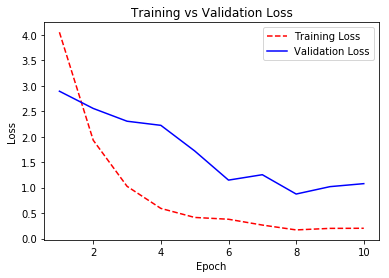

In [57]:
# Create count of the number of epochs
epoch_count = range(1,len(history.history['loss']) + 1)

# Visualize the learning curve.

plt.plot(epoch_count,history.history['loss'],'r--')
plt.plot(epoch_count,history.history['val_loss'],'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

# save figure
plt.savefig('../LSTM/figures/loss.png')

plt.show()

In [54]:
# Loss: A scalar value that we attempt to minimize during our training of the model. 
# The lower the loss, the closer our predictions are to the true labels.
# The lower the loss, the better a model (unless the model has over-fitted to the training data). 
# The loss is calculated on training and validation and its interperation is how well the model is doing for 
# these two sets. Unlike accuracy, loss is not a percentage. 
# It is a summation of the errors made for each example in training or validation sets.

In [58]:
# Predict validation sentiment!

y_pred = model.predict(X_val)

In [62]:
# Compile with more metrics to evaluate model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [63]:
# Keras doesn't have f1 score in metrics - therefore we have to manually calculate
from keras import backend as K

def recall_m(y_val, y_pred):
        true_positives = K.sum(K.round(K.clip(y_val * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_val, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_val, y_pred):
        true_positives = K.sum(K.round(K.clip(y_val * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_val, y_pred):
    precision = precision_m(y_val, y_pred)
    recall = recall_m(y_val, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [64]:
# Evaluate model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_val,y_val,verbose=1)

4956/4956 [==============================] - 12s 2ms/step


In [66]:
print(f"loss {loss}")
print(f"accuracy {accuracy}")
print(f"f1 score {f1_score}")
print(f"precision {precision}")
print(f"recall {recall}")

loss 0.6805312985658069
accuracy 0.8649448612411721
f1 score 0.796638385579892
precision 0.7996052223121668
recall 0.7937853105901421


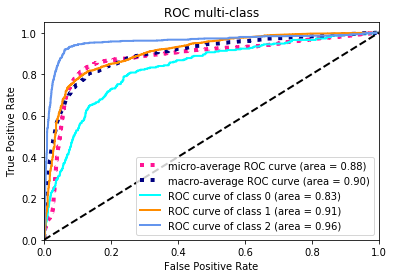

In [67]:
# Use trained Keras model to predict test inputs and generate ROC data
# Plot ROC for each of the 3 classes


import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# 3 classes to classify
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC multi-class')
plt.legend(loc="lower right")

# Save figure
plt.savefig('../LSTM/figures/roc.png')

plt.show()



In [68]:
# Keras and Sklearn read arrays differently
# Create function to convert keras array to show only one highest sentiment result per list
def keras_output_sklearn(y):
    
    result = []
    
    for element in y:
        result.append(np.argmax(element))
        

    return result

In [69]:
# use sklearn's confusion matrix to view correlation between truth and prediction
# use keras_output_sklearn function to reshape
confusion_matrix_t = confusion_matrix(keras_output_sklearn(y_val),keras_output_sklearn(y_pred))
# counts in each cell
confusion_matrix_t

array([[ 187,   69,   30],
       [ 622, 3017,  199],
       [  37,   50,  745]])

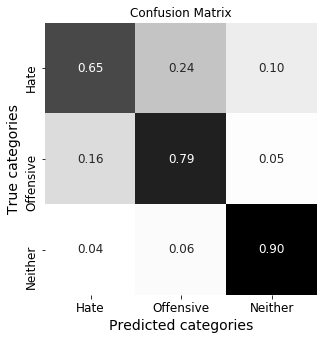

In [70]:
# Use seaborn to see counts in percentages
# Truth categories yield 100%
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix_t[i,:]/float(confusion_matrix_t[i,:].sum())
names=['Hate','Offensive','Neither']
# save result as pandas df
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.title('Confusion Matrix')
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
plt.savefig('../LSTM/figures/confusion.png')


In [ ]:
# Create joblib file
# from joblib import dump, load
# dump(model,'lstm.joblib')